In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
# TensorFlow imports
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib import pyplot as plt
from tensorflow.keras.utils import Sequence, to_categorical

from utils.eval_utils import (accuracy_metric, calibration, cindex,
                              cindex_metric)

tfd = tfp.distributions
tfkl = tf.keras.layers
tfpl = tfp.layers
tfk = tf.keras

import matplotlib.pyplot as plt

# VaDeSC model
from models.losses import Losses
from models.model import GMM_Survival

# Set Seaborn style for a cleaner look
sns.set(style="whitegrid")

os.chdir("/u/97/nguyenq10/unix/HUS/vadesc-torch")
print(os.getcwd())


import matplotlib.pyplot as plt

# VaDeSC model
from models.losses import Losses
from models.model import GMM_Survival

# Check if GPU is available
if tf.test.is_gpu_available():
  print("You are using GPU.")
  print("The GPU device name is:", tf.test.gpu_device_name())
else:
  print("You are using CPU.")

configs = {'data': {'data_name': 'support_'}, 'training': {'eval_frequency': 20, 'inp_shape': 59, 'latent_dim': 16, 'activation': 'none', 'monte_carlo': 1, 'learn_prior': True, 'weibull_shape': 2.0, 'survival': True, 'sample_surv': False}}
# Define reconstruction loss function



2024-02-01 14:25:03.383539: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-01 14:25:05.076861: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


/m/home/home9/97/nguyenq10/unix/HUS/vadesc-torch
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
You are using GPU.
The GPU device name is: /device:GPU:0


2024-02-01 14:25:22.089760: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-01 14:25:22.167446: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-01 14:25:22.581932: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-01 14:25:22.582321: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), bu

## Dataset

In [2]:
# from src.radcure import Radcure

def del_multicol(df):
    return df.drop(columns=df.filter(regex='^N Stage_N[1-9X]').columns).drop(columns=["T Stage_T3/4", "Stage_III/IV","ECOG_0"]) \
        .drop(columns=df.filter(regex='^Disease').columns).drop(columns="target_binary") \
        .drop(columns=["Sex_Female"])

# df_tr = Radcure.make_data("../data/radcure/clinical_train.csv")
# df_te = Radcure.make_data("/u/97/nguyenq10/unix/HUS/simpy-vadesc/data/radcure/clinical_test.csv")
df = pd.read_csv("./datasets/radcure/clinical_train.csv").drop(columns=["split","target_binary","Study ID"])
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
df.columns = [col.lower().strip() for col in df.columns]
display(df.head())

cat_feats = ["sex", "disease site", "t stage", "n stage", "hpv combined", "chemo?", "ecog", "stage"]
num_feats = ["age"]
outcomes = df[["death","survival_time"]].rename(columns={"death":"event","survival_time":"time"})
features = df.drop(columns=["death","survival_time"])

from auton_survival.preprocessing import Preprocessor

preprocessor = Preprocessor(cat_feat_strat='ignore', num_feat_strat= 'mean') 
x = preprocessor.fit_transform(features, cat_feats=cat_feats, num_feats=num_feats,
                                one_hot=True, fill_value=-1)
y = outcomes


from sklearn.model_selection import train_test_split


x_tr, x_val, y_tr, y_val = train_test_split(x, y, test_size=0.3, random_state=1) 

# Define the times for tuning the model hyperparameters and for evaluating the model
times = np.quantile(y_tr['time'][y_tr['event']==1], np.linspace(0.1, 1, 10)).tolist()
print(f'Number of training data points: {len(x_tr)}')
print(f'Number of validation data points: {len(x_val)}')
display(x.head())
display(y.head())

,age,sex,disease site,t stage,n stage,hpv combined,chemo?,ecog,stage,survival_time,death
0,66.7,male,larynx,t3,n0,NaN,0,0.0,iii,6.038356,0
1,68.4,female,hypopharynx,t2,n2b,NaN,0,1.0,iva,5.800000,0
2,49.7,female,nasopharynx,t1,n2,NaN,1,1.0,iii,7.556164,0
3,88.5,male,oropharynx,t2,n2a,NaN,0,2.0,iva,5.460274,0
4,69.8,male,oropharynx,t3,n2b,"yes, positive",0,0.0,iva,5.158904,0


Number of training data points: 1260
Number of validation data points: 540


,age,sex_male,disease site_hypopharynx,disease site_larynx,disease site_lip & oral cavity,disease site_nasal cavity,disease site_nasopharynx,disease site_oropharynx,disease site_paranasal sinus,disease site_salivary glands,...,ecog_4.0,stage_i,stage_ii,stage_iia,stage_iii,stage_iiia,stage_iiic,stage_iv,stage_iva,stage_ivb
0,0.397493,1,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0.541164,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,-1.039212,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,2.239856,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0.659480,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


,event,time
0,0,6.038356
1,0,5.800000
2,0,7.556164
3,0,5.460274
4,0,5.158904


## VaDeSC Model

In [3]:
configs = {'data': {'data_name': 'support_'}, 'training': {'eval_frequency': 20, 'inp_shape': 45, 'latent_dim': 16, 'activation': 'none', 'monte_carlo': 1, 'learn_prior': True, 'weibull_shape': 2.0, 'survival': True, 'sample_surv': False}}
# Define reconstruction loss function
loss = Losses(configs).loss_reconstruction_mse

class DataGen(Sequence):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __getitem__(self, index):
        return (self.X, self.y), {"output_1": self.X, "output_5": self.y}

    def __len__(self):
        return 1
    

# Create a tf.data.Dataset
train_data = tf.data.Dataset.from_tensor_slices((x_tr.values))
# Assuming x_tr is your numpy array of training data
gen_tr = DataGen(x_tr, y_tr)
gen_val = DataGen(x_val, y_val)

configs

2024-02-01 14:25:32.946300: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-01 14:25:32.946451: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-01 14:25:32.946508: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-01 14:25:32.948056: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-01 14:25:32.948151: I tensorflow/compiler/xla/stream_executo

{'data': {'data_name': 'support_'},
 'training': {'eval_frequency': 20,
  'inp_shape': 45,
  'latent_dim': 16,
  'activation': 'none',
  'monte_carlo': 1,
  'learn_prior': True,
  'weibull_shape': 2.0,
  'survival': True,
  'sample_surv': False}}

In [3]:
input_dim = 45
def loss_reconstruction_mse(self, inp, x_decoded_mean):
    x = inp
    loss = input_dim * tf.math.reduce_mean(tf.stack([tf.keras.losses.MeanSquaredError()(x, x_decoded_mean[i])
                                                            for i in range(x_decoded_mean.shape[0])], axis=-1),
                                                axis=-1)
    return loss

loss = loss_reconstruction_mse

{'k': 2, 'latent_dim': 16, 'activation': 'relu', 'monte_carlo': 1, 'learn_prior': False, 'weibull_shape': 2.5, 'sample_surv': False}


  1%|          | 7/1200 [00:00<00:19, 61.33it/s, loss=133, val_ctd=0.45] 

100%|██████████| 1200/1200 [00:34<00:00, 34.84it/s, loss=20.3, val_ctd=0.687]
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)


Stopped at epoch 1199
[[[0.14492900514192333], <vadesc.VaDeSC object at 0x7fbd991c2ee0>, {'k': 2, 'latent_dim': 16, 'layers': [50, 100], 'learning_rate': 0.001, 'seed': 1, 'weibull_shape': 2.5}]]


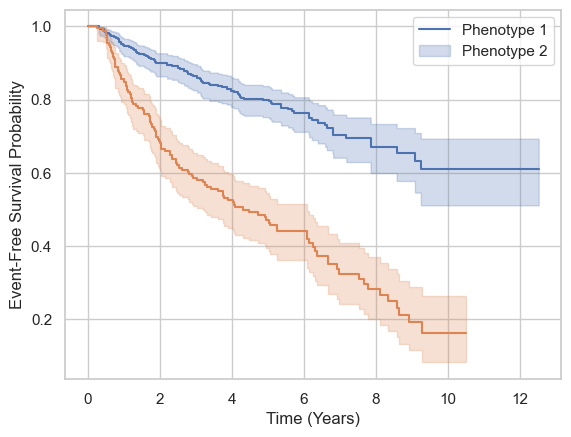

/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)


[0.14492900514192333]

In [9]:
from copy import deepcopy

import torch
from auton_survival.metrics import phenotype_purity, survival_regression_metric
from lifelines.utils import concordance_index
from sklearn.model_selection import ParameterGrid
from torch.utils.tensorboard.writer import SummaryWriter

# # Define parameters for tuning the model
param_grid = {'num_clusters': [2],
              'learning_rate': [1e-3],
              'layers': [[50,100]],
              'latent_dim': [16],
              'weibull_shape': [2.5],
              'seed': [1]
              }

writer = SummaryWriter()

# param_grid = {'k': [2],
#               'learning_rate': [9e-3],
#               'layers': [[32, 64]],
#               'latent_dim': [9],
#               'weibull_shape': [1.3581521669695251],
#               'seed': [0]
#               }

params = ParameterGrid(param_grid)

# Define the times for tuning the model hyperparameters and for evaluating the model
times = np.quantile(y_tr['time'][y_tr['event'] == 1],
                    np.linspace(0.1, 1, 10)).tolist()
# dflcfg = {'latent_dim': 16, 'activation': 'relu', 'monte_carlo': 1,
#        'learn_prior': True, 'weibull_shape': 2, 'sample_surv': False}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_cfg = {"num_clusters": 2, "latent_dim": 16, 'monte_carlo': 1,
            'learn_prior': False, 'weibull_shape': 2.0, 'sample_surv': False}
# Perform hyperparameter tuning
models = []
for param in params:
    cfg = deepcopy(base_cfg)
    for k, v in param.items():
        if k in cfg:
            cfg[k] = v
    print(cfg)
    model = GMM_Survival(**cfg)
    tf.keras.backend.set_value(model.use_t, np.array([1.0]))
    optimizer = tf.keras.optimizers.legacy.Adam(
        learning_rate=param["learning_rate"], decay=0.00001)
    model.compile(optimizer, loss={"output_1": loss}, run_eagerly=False,
                  metrics={"output_5": cindex_metric})
    history = model.fit(gen_tr, validation_data=gen_val, epochs=1000, verbose=0)
    # metric_val2 = survival_regression_metric('ctd', y_val, predictions_val, times, y_tr)
    risk = model.predict_risk(x_val)
    phenotypes = model.predict_latent_z(x_val)
    # Estimate the integrated Brier Score at event horizons of 1, 2 and 5 years
    metric_val1 = phenotype_purity(phenotypes_train=phenotypes, outcomes_train=y_val, 
                                    phenotypes_test=None, outcomes_test=None,
                                    strategy='integrated', horizons=[6], 
                                    bootstrap=None)
    # metric_val1 = survival_regression_metric(
    #     'ibs', y_val, predictions_val, times, y_tr)
    # metric_val2 = concordance_index(y_val.time, risk, y_val.event)

    models.append([metric_val1, model, param])

# Select the best model based on the mean metric value computed for the validation set
models = sorted(models, key=lambda x: x[0], reverse=True)
best_model = models[0][1]
print(models)

import matplotlib.pyplot as plt
from auton_survival import reporting
from auton_survival.metrics import phenotype_purity

# Estimate the probability of event-free survival for phenotypes using the Kaplan Meier estimator.
phe_tr = best_model.predict_latent_z(x_tr)
phe_val = best_model.predict_latent_z(x_val)
reporting.plot_kaplanmeier(y_val, groups=phe_val)

plt.xlabel('Time (Years)')
plt.ylabel('Event-Free Survival Probability')
plt.legend(['Phenotype 1', 'Phenotype 2'], loc="upper right")
plt.show()

# Estimate the Integrated Brier Score at event horizons of 1, 2 and 5 years
metric = phenotype_purity(phenotypes_train=phe_val, outcomes_train=y_val, 
                          strategy='integrated', horizons=[6],
                          bootstrap=None)
metric

Plotting the latent space...


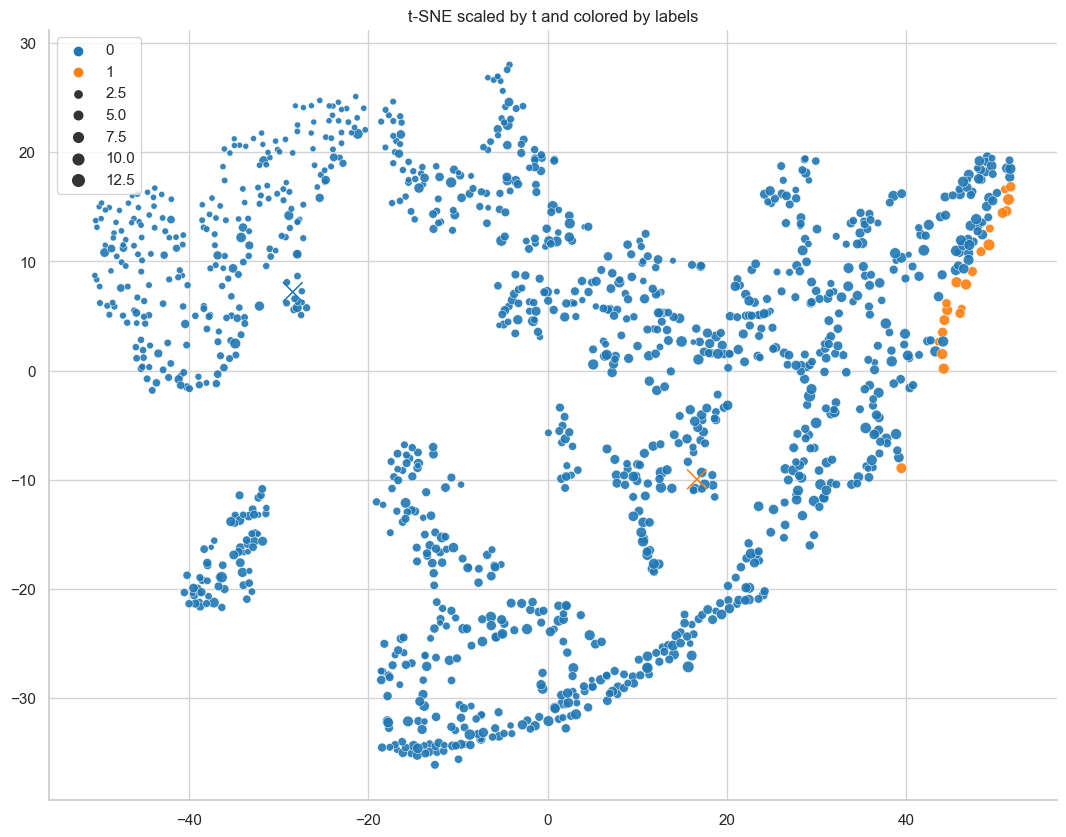

In [5]:
from vadesc.vadesc_utilities import plot_latents_
import torch

plot_latents_(model.torch_model,x=torch.from_numpy(x_tr.values).double(), t=torch.from_numpy(y_tr.time.values).double())

None

In [6]:
from auton_survival.models.dcm import DeepCoxMixtures
from auton_survival.metrics import survival_regression_metric
from sklearn.model_selection import ParameterGrid

# Define parameters for tuning the model
param_grid1 = {'k' : [2],
              'learning_rate' : [1e-3, 1e-4],
              'layers' : [[50, 100],[100]]
             }

params1 = ParameterGrid(param_grid1)

# Define the times for tuning the model hyperparameters and for evaluating the model
times = np.quantile(y_tr['time'][y_tr['event']==1], np.linspace(0.1, 1, 10)).tolist()

# Perform hyperparameter tuning 
models1 = []
for param in params1:
    model = DeepCoxMixtures(k=param['k'], layers=param['layers'],)
    
    # The fit method is called to train the model
    model.fit(x_tr, y_tr.time, y_tr.event, iters = 100, learning_rate=param['learning_rate'])

    phenotypes = np.argmax(model.predict_latent_z(x_val),-1)
    # Estimate the integrated Brier Score at event horizons of 1, 2 and 5 years
    metric_val1 = phenotype_purity(phenotypes_train=phenotypes, outcomes_train=y_val, 
                                    phenotypes_test=None, outcomes_test=None,
                                    strategy='integrated', horizons=[6], 
                                    bootstrap=None)
    # Obtain survival probabilities for validation set and compute the integrated Brier Score 
    # predictions_val = model.predict_survival(x_val, times)
    # metric_val2 = survival_regression_metric('ctd', y_val, predictions_val, times, y_tr)
    # metric_val1 = survival_regression_metric('ibs', y_val, predictions_val, times, y_tr)
    models1.append([metric_val1, model, param])
    
models1 = sorted(models1, key=lambda x: x[0], reverse=False)
model = models1[0][1]
print(models1)

  0%|          | 0/100 [00:00<?, ?it/s]


RuntimeError: expected scalar type Float but found Double

In [ ]:
print(models1)

[[[0.1371216714156939], <auton_survival.models.dcm.DeepCoxMixtures object at 0x7fea140a7f40>, {'k': 2, 'layers': [50, 100], 'learning_rate': 0.0001}], [[0.13863327990257449], <auton_survival.models.dcm.DeepCoxMixtures object at 0x7feac8adddc0>, {'k': 2, 'layers': [50, 100], 'learning_rate': 0.001}], [[0.13968305038262813], <auton_survival.models.dcm.DeepCoxMixtures object at 0x7feac8ad8610>, {'k': 2, 'layers': [100], 'learning_rate': 0.001}], [[0.14172855582930532], <auton_survival.models.dcm.DeepCoxMixtures object at 0x7feac8adde20>, {'k': 2, 'layers': [100], 'learning_rate': 0.0001}]]


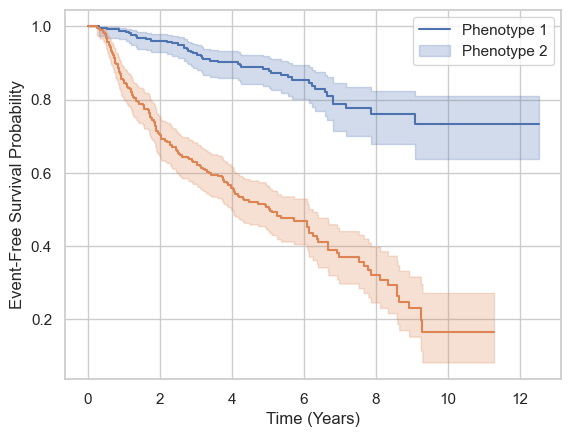

/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)


[0.1371216714156939]

In [ ]:
from auton_survival import reporting
import matplotlib.pyplot as plt
from auton_survival.models.dcm.dcm_utilities import predict_latent_z

latent_z_prob = model.predict_latent_z(x_val)
phenotypes = np.argmax(latent_z_prob, axis=-1)
# Estimate the probability of event-free survival for phenotypes using the Kaplan Meier estimator.
reporting.plot_kaplanmeier(y_val, np.array(phenotypes))

plt.xlabel('Time (Years)')
plt.ylabel('Event-Free Survival Probability')
plt.legend(['Phenotype 1', 'Phenotype 2'], loc="upper right")
plt.show()

# Estimate the integrated Brier Score at event horizons of 1, 2 and 5 years
metric = phenotype_purity(phenotypes_train=phenotypes, outcomes_train=y_val, 
                                phenotypes_test=None, outcomes_test=None,
                                strategy='integrated', horizons=[6], 
                                bootstrap=None)
metric

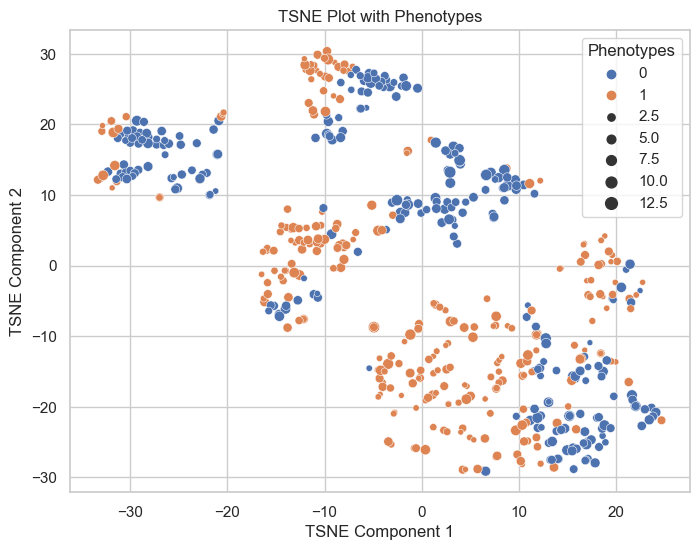

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=1)
x_tsne = tsne.fit_transform(x_val)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=x_tsne[:, 0], y=x_tsne[:, 1], hue=phenotypes, size=y_val.time)
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title('TSNE Plot with Phenotypes')
plt.legend(title='Phenotypes', loc='best')
plt.show()
